<b>Arnie Larson<br>
EEP 592 - Radar, Autumn 2022<br>
HW3<br>
10/25/2022</b>

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy import signal
from scipy.io import wavfile


<b>Overview</b>

HW3 has a final project proposal, a pen and penicl problem, and a coding problem, a continuation of our doppler simulations towards a stand alone program.

<b>1)</b><br>

Project Proposal

- What are the targets?
- How will you simulate expected Doppler returns?
- How will you gather data for this scenario?
- What interface will you provide for visualizing information?
- What are the key milestons and rough timeline?

For my project I'd primarily like to make a radar detection device, which can run on my residential block, classify (people/cars/bicycles) and determine speeds.  

An MVP level project would be a simple device connected to my laptop that will be located at an elevated location adjacent to the street which will detect targets.  It would output velocity and output target classification.  

I expect to do a lot of testing with my family for gathering data.  Hopefully a working classification system can be designed that is slightly more interesting than a simple rules based classifier.  

In a slightly more interesting final project - I would utilize the Pluto SDR and hopefully generate more robust classifications with the addition of range.
And in an even more interseting application I would deploy this with a Raspberry Pi and generate a more interesting user interface, possibly even taking pictures of fast moving cars.

I would like to test out using the Pluto SDR but it is not really known how much difficulty that could present with programming and using at this time.

Key Milestones:

1. Data Gathering:  Walking child, running child; walking adult; running adult; biking adult, biking child; car (10 sets or so per category?)  (1 week)  

2. Generating a prototype MVP program, signal processing + visualization (Python)  (1 week) 

3. Data Gathering with SDR (1-2 weeks)

4. Signal processing and generating an MVP program with Pluto SDR (1-2 weeks)

<b>2)</b><br>

6.34 Skolnik.  A X band radar (9375 MHz) is desired to achieve a 10kt (knot) radial velocity accuracy with $2E/N_0$ of 23dB

1 Knot = 1.51 mph = 0.514 m/s; 10 Knot = 5.14 m/s

Resolution in frequency from rectangular pulse $\delta f = \frac{\sqrt{3}}{\pi \tau (2E_0/N_0)^{\frac{1}{2}}}$  (From Skolnik, 11.29,  2nd ed)

a) What is the minimum width $\tau$ for a rectangular pulse?  <b>A: 0.12 ms</b>

b) What is the minimum range for this pulse width?  <b>A: 18 km</b>

c) What if $\tau = 10 \mu s$, what SNR will acheive this velocity resolution?  <b>A: $2E_0/N_0 = 44.7 dB$</b>

d) For radar operating at 94 GHz, in W-band, what pulse width would be required?  Since the doppler shift is bigger, the frequency resolution required is smaller, and a smaller pulse can be used.<b>A: 0.012 ms</b> 

e) To resolve velocity requires resolution of frequency.  Frequency resolution with a short pulse requires fast increase of the SNR.  Making the pulse smaller by a factor of 2 requires increasing the SNR by a factor of 2^2.

In [8]:
## Using basic doppler formula, find desired frequency resolution: 
ftx= 9375e6; c=3e8; lmbda=c/ftx;  v=5.14; fD= 2*v*ftx/c
SNR=200 #23 dB
## Pulse width; range resolution
#tau=1/fD; 
tau = np.sqrt(3)/(np.pi*fD*SNR**0.5)
r=c*tau/2

# If pulse is 10 micro sec, what SNR acheives this resolution?
SNR_10 = (np.sqrt(3)/(np.pi*10e-6*fD))**2
# for W-band
fD2= 2*v*94e9/c
tau2 = np.sqrt(3)/(np.pi*fD2*SNR**0.5)
print("Resolving 10 kt => doppler frequency ~ {:.1f} Hz".format(fD))
print("This doppler frequency resolution requires pulse width ~ {:.3f} ms ".format(tau*1e3))
print("Range resolution is ~ {:.1f} km ".format(r*1e-3))
print("The SNR to acheive resolution with 10 microsec pulse: {:.3f}".format(SNR_10))
print("(This SNR in dB : {:.1f})".format(10*np.log10(SNR_10)))
print("In W-band, w 23dB SNR, requires pulse width ~ {:.3f} ms ".format(tau2*1e3))

Resolving 10 kt => doppler frequency ~ 321.2 Hz
This doppler frequency resolution requires pulse width ~ 0.121 ms 
Range resolution is ~ 18.2 km 
The SNR to acheive resolution with 10 microsec pulse: 29453.387
(This SNR in dB : 44.7)
In W-band, w 23dB SNR, requires pulse width ~ 0.012 ms 


<b>3)</b><br>

Generate a program to process IF radar data (as if it is processing a signal stream) and emit target detection information. I consolidated my signal processing functions into a module which is imported here. 

- Generate car signal with infinite RCS
- Process car signal with program
- Generate car signal with normal dynamics and 60dB AWGN
- Process car signal with AWGN with program

In [9]:
import alarso_doppler as dop
from IPython.display import clear_output
import time

In [10]:
## Note implied precision of the doppler processing CW radar processing:
## 8000 Hz sample rate implies max frequency of 4000 is available.
## However when doing spectrogram, the default takes 256, implies 128 frequency bins
df = 4000/128;  print("Implied precistion +/- {:.3f} Hz".format(df/2))
c=3e8; ftx=10.5e9
dv = c*2*df/(2*ftx);  print("Implied velocity resolution precistion +/- {:.3f} m/s".format(dv/2))
## Sanity check
vmax=4000*c/(2*ftx);  print("Max velocity processible: {:.3f} m/s".format(vmax))

Implied precistion +/- 15.625 Hz
Implied velocity resolution precistion +/- 0.446 m/s
Max velocity processible: 57.143 m/s


In [11]:
S1 = dop.generate( sim='car_ircs', fname='car_ircs.wav')

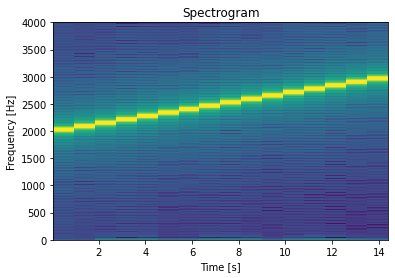

Average noise power at 3900 Hz: 0.000
Setting target threshold to: 0.00
t = 1 s, v = 28.77 [m/s], v = 64.35 mph, target: 10024296.79, fD: 2013.67 [Hz]
t = 2 s, v = 29.66 [m/s], v = 66.35 mph, target: 9999561.53, fD: 2076.17 [Hz]
t = 3 s, v = 31.25 [m/s], v = 69.90 mph, target: 10023438.69, fD: 2187.50 [Hz]
t = 4 s, v = 32.14 [m/s], v = 71.90 mph, target: 10024908.78, fD: 2250.00 [Hz]
t = 5 s, v = 32.35 [m/s], v = 72.37 mph, target: 10027018.79, fD: 2264.65 [Hz]
t = 6 s, v = 33.24 [m/s], v = 74.37 mph, target: 10013178.00, fD: 2327.15 [Hz]
t = 7 s, v = 34.84 [m/s], v = 77.92 mph, target: 10015610.64, fD: 2438.48 [Hz]
t = 8 s, v = 35.73 [m/s], v = 79.92 mph, target: 10027064.67, fD: 2500.98 [Hz]
t = 9 s, v = 35.94 [m/s], v = 80.39 mph, target: 10025727.68, fD: 2515.62 [Hz]
t = 10 s, v = 36.83 [m/s], v = 82.39 mph, target: 10022053.55, fD: 2578.12 [Hz]
t = 11 s, v = 38.42 [m/s], v = 85.94 mph, target: 10003093.06, fD: 2689.45 [Hz]
t = 12 s, v = 39.31 [m/s], v = 87.94 mph, target: 10025288

In [12]:
f, t, S = dop.process_signal(S1)

In [6]:
S2 = dop.generate( sim='car_60db', fname='car_60db.wav')

Generating 60 dB noise, S_max: 10.000, sigma: 0.010


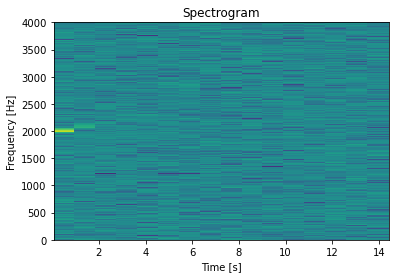

Average noise power at 3900 Hz: 0.378
Setting target threshold to: 5.67
t = 1 s, v = 28.71 [m/s], v = 64.22 mph, target power: 29562.91, fD: 2009.77 [Hz]
t = 2 s, v = 29.67 [m/s], v = 66.38 mph, target power: 12.94, fD: 2077.15 [Hz]
t = 3, no target
t = 4, no target
t = 5, no target
t = 6, no target
t = 7, no target
t = 8, no target
t = 9, no target
t = 10, no target
t = 11, no target
t = 12, no target
t = 13, no target
t = 14, no target
t = 15, no target
t = 16, no target


In [7]:
f, t, S = dop.process_signal(S2)

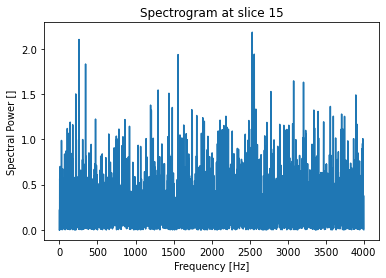

In [8]:
# Can visualize how the power spectrum evolves with time
for i in range(S.shape[1]):
    clear_output(wait=True)
    plt.plot(f, S[:,i])
    plt.xlabel("Frequency [Hz]"), plt.ylabel("Spectral Power []")
    plt.title("Spectrogram at slice {}".format(i))
    plt.show()
    time.sleep(0.5)
    
    